In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [2]:
dff = pd.read_csv("TSLA.csv")
dff.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2579,2020-09-25,393.470001,408.730011,391.299988,407.339996,407.339996,67208500
2580,2020-09-28,424.619995,428.079987,415.549988,421.200012,421.200012,49719600
2581,2020-09-29,416.000000,428.500000,411.600006,419.070007,419.070007,50219300
2582,2020-09-30,421.320007,433.929993,420.470001,429.010010,429.010010,47923700
2583,2020-10-01,440.760010,448.880005,434.420013,448.160004,448.160004,50741500


In [3]:
df = dff

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2584 non-null   object 
 1   Open       2584 non-null   float64
 2   High       2584 non-null   float64
 3   Low        2584 non-null   float64
 4   Close      2584 non-null   float64
 5   Adj Close  2584 non-null   float64
 6   Volume     2584 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 141.4+ KB


In [5]:
df.shape

(2584, 7)

In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index(df["Date"], inplace = True)
df1 = df.drop(["Date"], axis = "columns")
df1.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


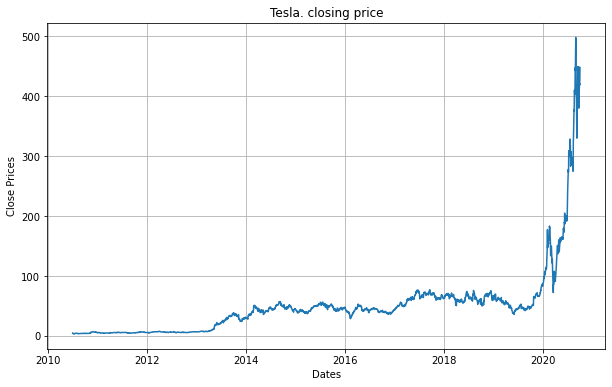

In [8]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df1['Close'])
plt.title('Tesla. closing price')
plt.show()


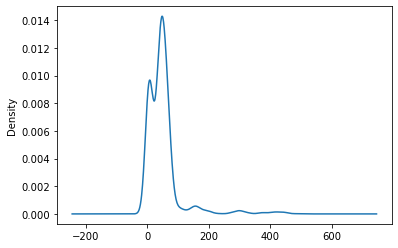

In [9]:
df1["Close"].plot(kind = "kde")

In [10]:
df_close = df1["Close"]

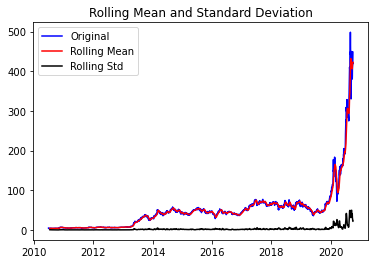

Results of dickey fuller test
Test Statistics                   6.190714
p-value                           1.000000
No. of lags used                 27.000000
Number of observations used    2556.000000
critical value (1%)              -3.432911
critical value (5%)              -2.862671
critical value (10%)             -2.567372
dtype: float64


In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

<ipython-input-12-7d28f8538da7>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_close, model='multiplicative', freq = 30)


<Figure size 432x288 with 0 Axes>

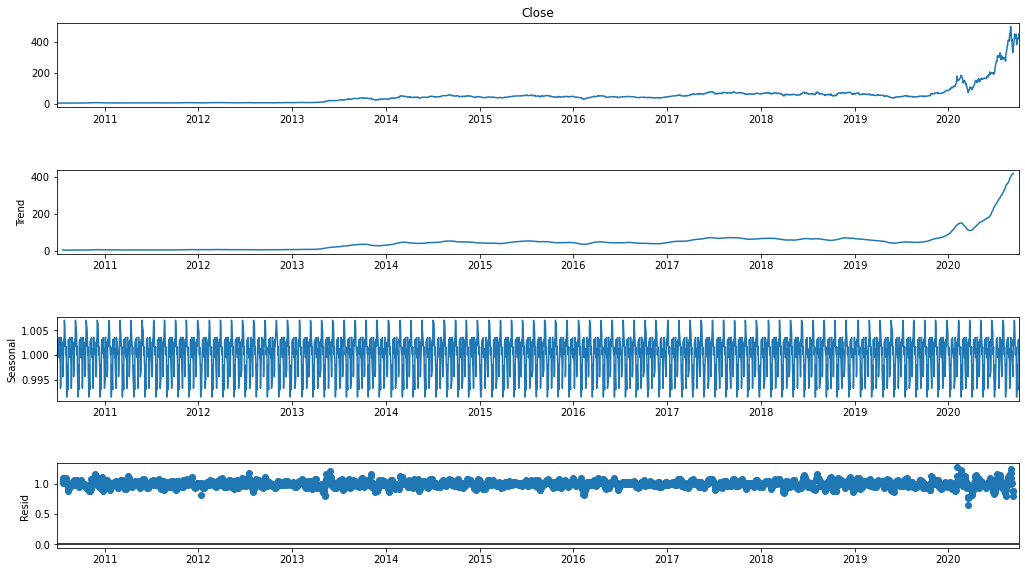

In [12]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


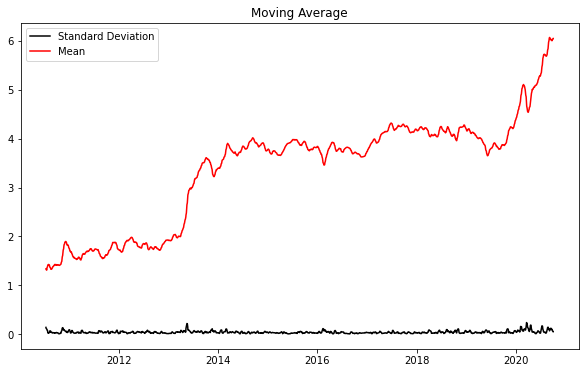

In [13]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [14]:
df_log_moving_avg_diff = df_log-moving_avg
df_log_moving_avg_diff.dropna(inplace=True)

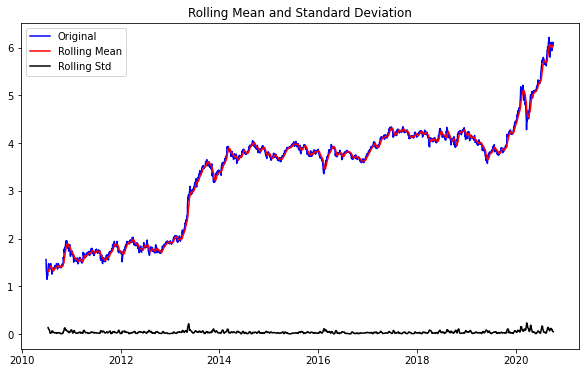

Results of dickey fuller test
Test Statistics                   0.225368
p-value                           0.973649
No. of lags used                  0.000000
Number of observations used    2583.000000
critical value (1%)              -3.432884
critical value (5%)              -2.862660
critical value (10%)             -2.567366
dtype: float64


In [15]:
test_stationarity(df_log)

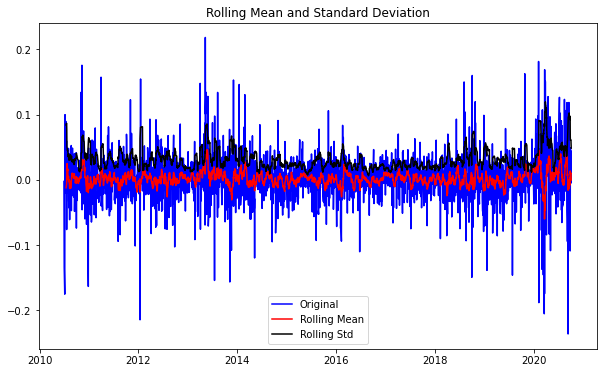

Results of dickey fuller test
Test Statistics                 -50.322735
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    2582.000000
critical value (1%)              -3.432885
critical value (5%)              -2.862660
critical value (10%)             -2.567366
dtype: float64


In [16]:
df_log_diff = df_log - df_log.shift()
df_log_diff.dropna(inplace = True)
test_stationarity(df_log_diff)

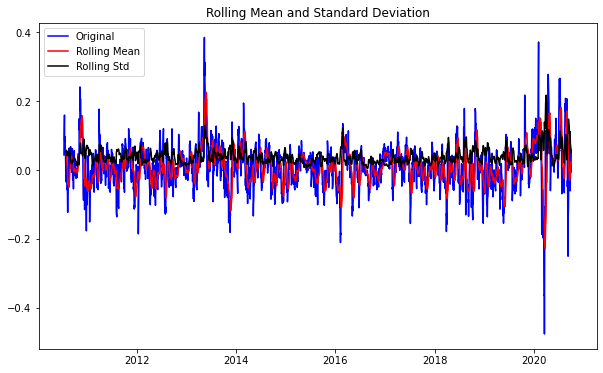

Results of dickey fuller test
Test Statistics               -1.439030e+01
p-value                        8.847686e-27
No. of lags used               3.000000e+00
Number of observations used    2.569000e+03
critical value (1%)           -3.432898e+00
critical value (5%)           -2.862666e+00
critical value (10%)          -2.567369e+00
dtype: float64


In [17]:
test_stationarity(df_log_moving_avg_diff)

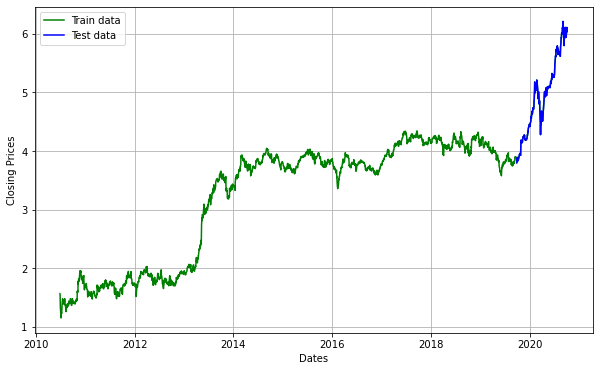

In [18]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [19]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9371.803, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9370.290, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9370.321, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9371.128, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9369.894, Time=1.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.361 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2322
Model:               SARIMAX(0, 1, 0)   Log Likelihood                4687.902
Date:                Tue, 26 Jan 2021   AIC                          -9371.803
Time:                        14:37:02   BIC                          -9360.304
Sample:                             0   HQIC                         -9367.613
                               - 2322                                  

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9371.803, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9370.290, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9370.321, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9371.128, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9369.894, Time=1.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.314 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2322
Model:               SARIMAX(0, 1, 0)   Log Likelihood                4687.902
Date:                Tue, 26 Jan 2021   AIC                          -9371.803
Time:                        14:37:04   BIC                          -9360.304
Sample:                             0   HQIC                         -9367.613
                               - 2322                                  

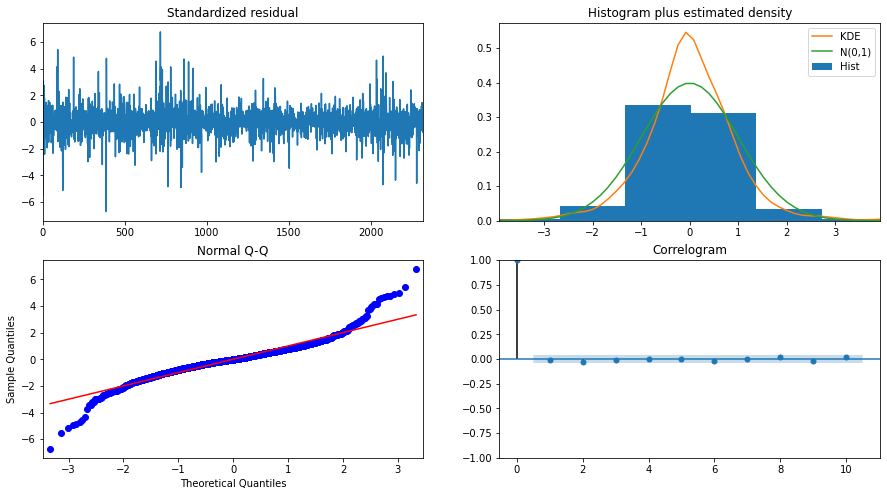

In [20]:

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [21]:
model = ARIMA(train_data, order=(2, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/Users/hemal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/hemal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/hemal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/hemal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Us

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2321
Model:                 ARIMA(2, 1, 2)   Log Likelihood                4694.193
Method:                       css-mle   S.D. of innovations              0.032
Date:                Tue, 26 Jan 2021   AIC                          -9376.386
Time:                        14:37:07   BIC                          -9341.888
Sample:                             1   HQIC                         -9363.814
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.645      0.100      -0.000       0.002
ar.L1.D.Close    -0.3012      0.001   -266.381      0.000      -0.303      -0.299
ar.L2.D.Close    -0.9994      0.001  -16

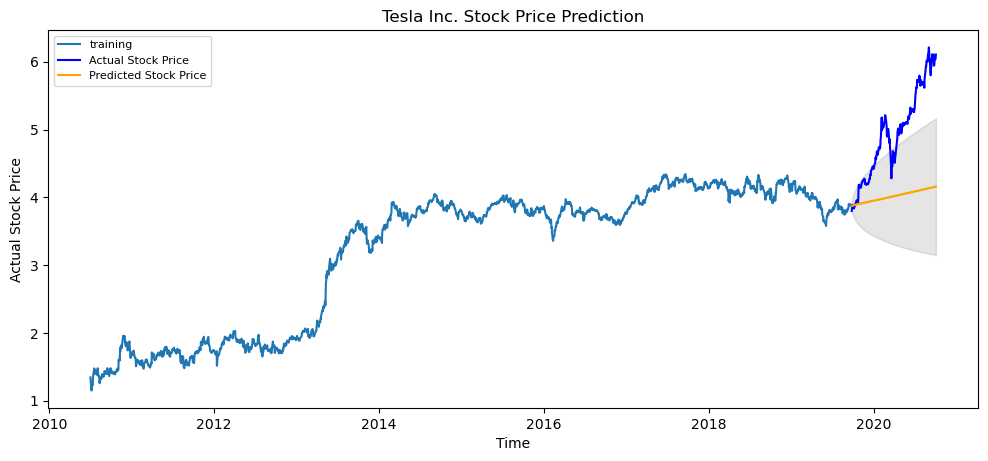

In [23]:
# Forecast
fc, se, conf = fitted.forecast(259, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Tesla Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [24]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 1.2126309269563653
MAE: 0.9386986367258866
RMSE: 1.101195226540855
MAPE: 0.17723092872203275
